# Demasculinization of the X

Here I look at the demasculinization of the X chromosome and how it relates to gene movement and cell type specific expression.

**Sex Bias Expression**: To determine genes with sex bias expression, I am using bulk RNA-Seq data generated by Sharvani for testis and ovary(TCP and OCP). These samples are dissected larval gonads treated with papain to remove fat, but they were not dissociated.

**New Genes**: Maria V. has sent me an updated list from Yong Zhang based on methods described [here](https://genome.cshlp.org/content/20/11/1526.full). I am using data from genes that were either duplicates or retrotransposition events moving from one chromosome to another. The table includes the parent gene ID, allowing use to look not only at the location of the new gene, but where the parent was located as well.

**Cell Type Expression**: For assessing cell type expression I have done additional differential expression analyses comparing different groups of cell types. For the Germ Cell vs Somatic Cell comparisons, I use DEG from comparing the germ cell clusters vs the somatic cell clusters. While for the 1º spermatocyte comparison I tested for differential expression comparing Early vs Late 1º Spermatocytes.

Since these are all contingency type comparisons I use a Fisher's Exact test. If I expect enrichment or depletion then I use the corresponding 1-sided test. Within an experiment, if I have multiple tests (i.e., by chromosome) I adjusted the p-value using Benjamini-Hochberg FDR. I assume an alpha of 0.05 for all tests

In [18]:
import os
import sys
from pathlib import Path

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd
from scipy.stats import fisher_exact
from statsmodels.sandbox.stats.multicomp import multipletests

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
from larval_gonad.notebook import Nb
from larval_gonad.plotting import make_figs
from larval_gonad.config import memory
from larval_gonad.x_to_a import strip_chr
from larval_gonad.scRNAseq import CLUSTER_ANNOT, CLUSTER_ORDER

# Setup notebook
nbconfig = Nb.setup_notebook(seurat_dir='../output/scrnaseq_combine_force')

last updated: 2018-05-11 
Git hash: 24131ab928c3728f9d1a9a7071609d227c96d379


In [19]:
def multi_idx(idx):
    l1 = [idx.name, ] * 2
    return pd.MultiIndex.from_arrays([l1, idx], names=['', ''])

def pretty(df, crosstab=False):
    _df = df.copy()
    if crosstab:
        _df.index = multi_idx(df.index)
        _df.columns = multi_idx(df.columns)
        
    display(HTML(_df.to_html(classes='table table-striped')))

In [20]:
# get bulk RNA-seq data
df = pd.read_csv('../bulk-rnaseq-wf/downstream/tod.tsv', sep='\t', index_col=0)
df.index.name = 'FBgn'

# Drop ERCC info
df = df[~df.index.str.startswith('ERCC')]

# make sure FBgns from workflow match my current annotation.
wfFbgn = df.index.unique().tolist()
myFbgn = list(nbconfig.fbgn2symbol.keys())
bad = []
for g in wfFbgn:
    assert g in myFbgn

# Split out the different gene sets
male_bias = df[(df.log2FoldChange > 0) & (df.padj <=0.001)].index.unique().tolist()
female_bias = df[(df.log2FoldChange < 0) & (df.padj <=0.001)].index.unique().tolist()
non_bias = df[(df.padj >0.001) | df.padj.isnull()].index.unique().tolist()

assert df.shape[0] == len(male_bias) + len(female_bias) + len(non_bias)

chrom = nbconfig.fbgn2chrom.query('chrom != "chrM"').copy()
chrom['Male-Bias'] = False
chrom['Female-Bias'] = False
chrom['Non-Bias'] = True

chrom.loc[chrom.index.isin(male_bias), 'Male-Bias'] = True
chrom.loc[chrom.index.isin(female_bias), 'Female-Bias'] = True
chrom.loc[chrom.index.isin(male_bias + female_bias), 'Non-Bias'] = False

## The 2R, X, Y, and 4th chromosomes are depleted for male-bias expression

In [21]:
def enrichment_by_chrom(dat, chrom=None, column=None, alternative='greater'):
    res = []
    for chromosome in dat[chrom].unique():
        _dat = dat.copy()
        _dat['current_chrom'] = False
        _dat.loc[_dat[chrom] == chromosome, 'current_chrom'] = True
        
        ctable = pd.crosstab(_dat['current_chrom'], _dat[column])
        res.append((chromosome, *fisher_exact(ctable, alternative=alternative)))
        
    df = pd.DataFrame(res, columns=['chrom', 'odds_ratio', 'p_val'])
    df.set_index('chrom', inplace=True)
    df['adj_p_val'] = multipletests(df.p_val, method='fdr_bh')[1]
    
    return df

In [22]:
pretty(enrichment_by_chrom(chrom, 'chrom', 'Male-Bias', alternative='less'))

,odds_ratio,p_val,adj_p_val
chrom,,,
chrX,0.753043,7.251562e-10,5.076093e-09
chr3L,1.078741,9.700469e-01,9.999146e-01
chr2L,1.162857,9.999146e-01,9.999146e-01
chr3R,1.146072,9.998510e-01,9.999146e-01
chr2R,0.902535,6.147767e-03,1.075859e-02
chr4,0.371955,4.092254e-05,9.548592e-05
chrY,0.364226,2.607282e-05,9.125488e-05


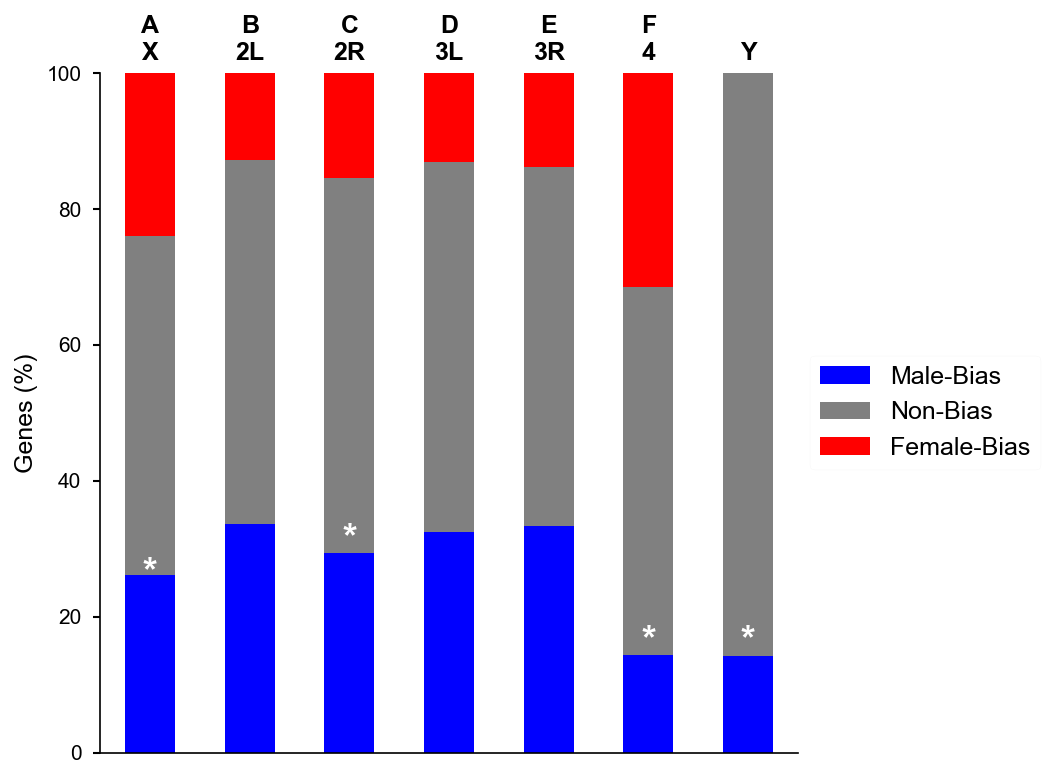

In [23]:
# Make plot like in sturgill 2007
def sturgillize(ax):
    ax.text(0, 102, 'A\nX', fontsize=12, fontweight='bold', ha='center')
    ax.text(1, 102, 'B\n2L', fontsize=12, fontweight='bold', ha='center')
    ax.text(2, 102, 'C\n2R', fontsize=12, fontweight='bold', ha='center')
    ax.text(3, 102, 'D\n3L', fontsize=12, fontweight='bold', ha='center')
    ax.text(4, 102, 'E\n3R', fontsize=12, fontweight='bold', ha='center')
    ax.text(5, 102, 'F\n4', fontsize=12, fontweight='bold', ha='center')
    ax.text(6, 102, '\nY', fontsize=12, fontweight='bold', ha='center')
    
    strip_chr(ax)
    for l in ax.get_xticklabels():
        l.set_rotation(0)
        
    ax.xaxis.set_visible(False)
    ax.set_ylabel('Genes (%)')
    ax.set_ylim(0, 100)
    sns.despine()
    
def sturgill_plot(dat, stars=None):
    order_cols = ['Male-Bias', 'Non-Bias', 'Female-Bias']
    order_rows = ['chrX', 'chr2L', 'chr2R', 'chr3L', 'chr3R', 'chr4', 'chrY']
    
    _sums = dat.groupby('chrom').sum()
    _totals = _sums.sum(axis=1)
    _pcts = _sums.div(_totals, axis='index') * 100
    
    fig, ax = plt.subplots()
    _pcts.loc[order_rows, order_cols].plot(kind='bar', stacked=True, color=['b', 'grey', 'r'], ax=ax)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    
    if stars is not None:
        for star in stars:
            ax.text(*star, '*', fontsize=18, fontweight='bold', color='white', ha='center')
            
    sturgillize(ax)
    

sturgill_plot(chrom, [(0, 25), (2, 30), (5, 15), (6, 15)])

## New Genes Summary

In [24]:
newGenes = pd.read_csv('../output/new_genes.tsv', sep='\t', index_col=0)

In [25]:
pretty(newGenes.chrom.value_counts().to_frame().join(newGenes.parent_chrom.value_counts().to_frame()))

,chrom,parent_chrom
chr2L,128,98
chr3R,116,118
chrX,107,119
chr3L,105,108
chr2R,92,110
chrY,9,3
chr4,1,2


In [26]:
_df = (newGenes.parent_chrom + ' -> ' + newGenes.chrom).value_counts().to_frame()
_df.index.name = 'Movement Direction'
_df.columns = ['count']
pretty(_df)

,count
Movement Direction,
chr3R -> chr3L,40
chrX -> chr2L,38
chr3L -> chrX,34
chr2R -> chr2L,34
chr2L -> chr3R,33
chrX -> chr3R,32
chr2R -> chr3R,30
chr3R -> chr2L,27
chr3L -> chr2L,27


## New genes are enriched on the X and Y.

In [27]:
dat = chrom.copy()
dat['new_gene'] = False
dat.loc[dat.index.isin(newGenes.index), 'new_gene'] = True

In [28]:
pretty(enrichment_by_chrom(dat, chrom='chrom', column='new_gene', alternative='greater'))

,odds_ratio,p_val,adj_p_val
chrom,,,
chrX,1.345994,0.004816,0.033682
chr3L,0.950808,0.693254,0.993717
chr2L,1.213412,0.034869,0.081362
chr3R,0.838930,0.958097,0.993717
chr2R,0.759314,0.993717,0.993717
chr4,0.277248,0.972019,0.993717
chrY,2.678594,0.009624,0.033682


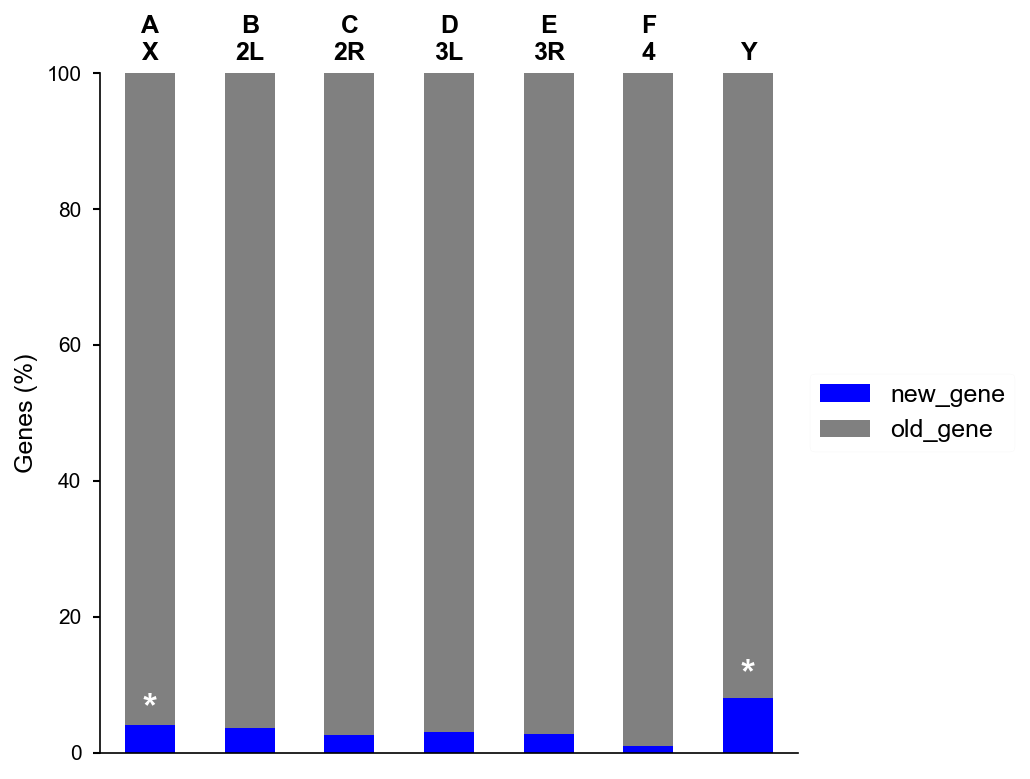

In [29]:
def newgene_plot(dat, stars=None):
    order_cols = ['new_gene', 'old_gene']
    order_rows = ['chrX', 'chr2L', 'chr2R', 'chr3L', 'chr3R', 'chr4', 'chrY']
    
    _dat = dat.copy()
    _dat['old_gene'] = ~_dat['new_gene']
    _sums = _dat[['chrom', 'new_gene', 'old_gene']].groupby('chrom').sum()
    _totals = _sums.sum(axis=1)
    _pcts = _sums.div(_totals, axis='index') * 100
    
    fig, ax = plt.subplots()
    _pcts.loc[order_rows, order_cols].plot(kind='bar', stacked=True, color=['b', 'grey', 'r'], ax=ax)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    
    if stars is not None:
        for star in stars:
            ax.text(*star, '*', fontsize=18, fontweight='bold', color='white', ha='center')
            
    sturgillize(ax)
    

newgene_plot(dat, [(0, 5), (6, 10)])

## New genes are enriched for male-bias expression

In [30]:
ct = pd.crosstab(dat['Male-Bias'], dat['new_gene'])
pretty(ct, crosstab=True)
print('Odds-Ratio: {:.4f} p-value: {:.4E}'.format(*fisher_exact(ct, 'greater')))

Odds-Ratio: 2.5741 p-value: 1.4684E-27


## Male-bias new genes are enriched on the X and Y chromosomes

In [31]:
datMB = dat.loc[dat['Male-Bias']].copy()

In [32]:
pretty(enrichment_by_chrom(datMB, 'chrom', 'new_gene', 'greater'))

,odds_ratio,p_val,adj_p_val
chrom,,,
chrX,2.081869,1.536157e-06,5.376549e-06
chr2L,1.056682,3.737988e-01,8.721972e-01
chr3L,0.909465,7.550137e-01,9.988949e-01
chr3R,0.642313,9.988949e-01,9.988949e-01
chr2R,0.698280,9.886403e-01,9.988949e-01
chr4,1.173243,5.876763e-01,9.988949e-01
chrY,23.295704,2.741852e-08,1.919296e-07


## Genes with male-bias expression are enriched in germ cells

In [33]:
# get background set from scRNA-seq data (genes with >0 reads)
norm = nbconfig.seurat.get_normalized_read_counts()
scOn = norm.index[(norm.sum(axis=1) > 0)].unique().tolist()

In [34]:
Markdown(f"""
**WARNING**: It is difficult to define the background gene set here. 
Now I am using if a gene was captured in the scRNA-Seq data (n={len(scOn):,}).
""")


**WARNING**: It is difficult to define the background gene set here. 
Now I am using if a gene was captured in the scRNA-Seq data (n=14,264).


In [35]:
# Get differentail expression results comparing germ line clusters vs somatic cell clusters
biomarkers = pd.read_csv('../output/scrnaseq_combine_force/2018-05-10_scrnaseq_germ_vs_soma_biomarkers.tsv', sep='\t')
biomarkers.set_index('primary_FBgn', inplace=True)
biomarkers.index.name = 'FBgn'
germ_bias = biomarkers[(biomarkers.p_val_adj <= 0.01) & (biomarkers.avg_logFC > 0)].index.unique().tolist()
soma_bias = biomarkers[(biomarkers.p_val_adj <= 0.01) & (biomarkers.avg_logFC < 0)].index.unique().tolist()

In [36]:
# Create germ cell and somatic cells dummies
scdat = dat[dat.index.isin(scOn)].copy()
scdat['germ_bias'] = False
scdat['soma_bias'] = False
scdat.loc[scdat.index.isin(germ_bias), 'germ_bias'] = True
scdat.loc[scdat.index.isin(soma_bias), 'soma_bias'] = True

In [37]:
ct = pd.crosstab(scdat['Male-Bias'], scdat['germ_bias'])
pretty(ct, crosstab=True)
print('Odds-Ratio: {:.4f} p-value: {:.4E}'.format(*fisher_exact(ct, 'greater')))

Odds-Ratio: 52.3411 p-value: 0.0000E+00


## New genes are enriched in germ cells

In [38]:
ct = pd.crosstab(scdat['new_gene'], scdat['germ_bias'])
pretty(ct, crosstab=True)
print('Odds-Ratio: {:.4f} p-value: {:.4E}'.format(*fisher_exact(ct, 'greater')))

Odds-Ratio: 3.9919 p-value: 4.9721E-42


## Genes with male-bias expression are enriched in early 1º spermatocytes and depleted in late 1º spermatocytes

In [39]:
late_biomarkers = pd.read_csv('../output/scrnaseq_combine_force/2018-05-10_scrnaseq_early_spermatocytes_vs_late_spermatocytes_biomarkers.tsv', sep='\t')
late_biomarkers.set_index('primary_FBgn', inplace=True)
late_biomarkers.index.name = 'FBgn'
late_bias = biomarkers[(biomarkers.p_val_adj <= 0.01) & (biomarkers.avg_logFC < 0)].index.unique().tolist()
early_bias = biomarkers[(biomarkers.p_val_adj <= 0.01) & (biomarkers.avg_logFC > 0)].index.unique().tolist()

In [40]:
scdat['late_bias'] = False
scdat['early_bias'] = False
scdat.loc[scdat.index.isin(late_bias), 'late_bias'] = True
scdat.loc[scdat.index.isin(early_bias), 'early_bias'] = True

In [41]:
ct = pd.crosstab(scdat['Male-Bias'], scdat['early_bias'])
pretty(ct, crosstab=True)
print('Odds-Ratio: {:.4f} p-value: {:.4E}'.format(*fisher_exact(ct, 'greater')))

Odds-Ratio: 52.3411 p-value: 0.0000E+00


In [42]:
ct = pd.crosstab(scdat['Male-Bias'], scdat['late_bias'])
pretty(ct, crosstab=True)
print('Odds-Ratio: {:.4f} p-value: {:.4E}'.format(*fisher_exact(ct, 'less')))

Odds-Ratio: 0.3058 p-value: 6.1462E-51


## New genes are enriched in early 1º spermatocytes and depleted in late 1º spermatocytes

In [43]:
ct = pd.crosstab(scdat['new_gene'], scdat['early_bias'])
pretty(ct, crosstab=True)
print('Odds-Ratio: {:.4f} p-value: {:.4E}'.format(*fisher_exact(ct, 'greater')))

Odds-Ratio: 3.9919 p-value: 4.9721E-42


In [44]:
ct = pd.crosstab(scdat['new_gene'], scdat['late_bias'])
pretty(ct, crosstab=True)
print('Odds-Ratio: {:.4f} p-value: {:.4E}'.format(*fisher_exact(ct, 'less')))

Odds-Ratio: 0.2330 p-value: 2.1757E-07
